In [ ]:
!pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40391 sha256=33eac90636d20017668c6072a3a4fce735c453ef2a913105705ec89977e766c2
  Stored in directory: /root/.cache/pip/wheels/52/aa/29/604a0a26abba1522c308e6bae4a61f3b29f85240b50843d604
Successfully built pybbn


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# for creating Bayesian Belief Networks(BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge,EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
# set pandas options to display columns
pd.options.display.max_columns=0

In [ ]:
# Read in the weather data csv
df=pd.read_csv("weatherAUS.csv",encoding='utf-8')

# drop records where target RainTomorrw=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]
#for other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else
                                                              '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

print(df)

              Date Location  ...  Humidity9amCat  Humidity3pmCat
0       2008-12-01   Albury  ...           1.>60          0.<=60
1       2008-12-02   Albury  ...          0.<=60          0.<=60
2       2008-12-03   Albury  ...          0.<=60          0.<=60
3       2008-12-04   Albury  ...          0.<=60          0.<=60
4       2008-12-05   Albury  ...           1.>60          0.<=60
...            ...      ...  ...             ...             ...
145454  2017-06-20    Uluru  ...          0.<=60          0.<=60
145455  2017-06-21    Uluru  ...          0.<=60          0.<=60
145456  2017-06-22    Uluru  ...          0.<=60          0.<=60
145457  2017-06-23    Uluru  ...          0.<=60          0.<=60
145458  2017-06-24    Uluru  ...          0.<=60          0.<=60

[142193 rows x 26 columns]


<ipython-input-11-56c6848cebc0>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [ ]:
def probs(data, child, parent1=None, parent2=None):
  if parent1==None:
    prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
  elif parent1 != None:
    if parent2==None:
      prob=pd.crosstab(data[parent1], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd.crosstab([data[parent1], data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
  else: print("Error in Probability Frequency Calculations")
  return prob

In [ ]:
H9am=BbnNode(Variable(0, 'H9am', ['<=60','>60']),probs(df, child='Humidity9amCat'))
H3pm=BbnNode(Variable(1, 'H3pm', ['<=60','>60']),probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W=BbnNode(Variable(2, 'W', ['<=40', '40-50','>50']),probs(df, child='WindGustSpeedCat'))
RT=BbnNode(Variable(3, 'RT', ['No','Yes']),probs(df, child='RainTomorrow',parent1='Humidity3pmCat',parent2='WindGustSpeedCat'))

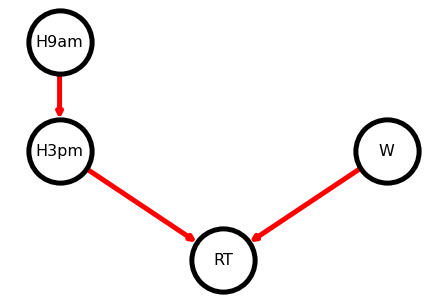

In [ ]:
bbn = Bbn() \
      .add_node(H9am) \
      .add_node(H3pm) \
      .add_node(W) \
      .add_node(RT) \
      .add_edge(Edge(H9am,H3pm,EdgeType.DIRECTED)) \
      .add_edge(Edge(H3pm,RT,EdgeType.DIRECTED)) \
      .add_edge(Edge(W,RT,EdgeType.DIRECTED)) 
join_tree = InferenceController.apply(bbn)
pos={0: (-1,2), 1: (-1,0.5), 2: (1,0.5), 3: (0,-1)}

options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color":"white",
    "edgecolors":"black",
    "edge_color":"red",
    "linewidths": 5,
    "width":5,
}

n,d=bbn.to_nx_graph()
nx.draw(n,with_labels=True, labels=d,pos=pos,**options)
ax=plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()